## Computing the Casimir energy between two cubes

### Background

In this tutorial, we are going to compute the Casmir energy between two cubes. 

The formula of computing the Casimir energy $\mathcal{E}$ between two objects can be written as 
$$  \mathcal{E} = -\frac{\hbar c}{2\pi}\int_{0}^{\infty}dk\log\frac{\det M(\mathrm{i}k)}{\det M_{\infty}(\mathrm{i}k)}, $$
where $$M(\mathrm{i}k) = 
        \begin{bmatrix}
            M_{11}(\mathrm{i}k) & M_{12}(\mathrm{i}k) \\
            M_{21}(\mathrm{i}k) & M_{22}(\mathrm{i}k) 
        \end{bmatrix}$$
is a two by two block matrix with its elements defined as
$$ M_{11}^{(m,n)}(\mathrm{i}k)
 = \int\int \mathbf{f}_{m}(\mathbf{x})\cdot\mathbf{G}_{\mathrm{i}k}(\mathbf{x},\mathbf{y})\cdot\mathbf{f}_{n}(\mathbf{y})d\mathbf{x}d\mathbf{y},    \\
M_{12}^{(m,n)}(\mathrm{i}k) = \int\int \mathbf{f}_{m}(\mathbf{x})\cdot\mathbf{G}_{\mathrm{i}k}(\mathbf{x},\mathbf{y})\cdot\mathbf{g}_{n}(\mathbf{y})d\mathbf{x}d\mathbf{y},\\
    M_{21}^{(m,n)}(\mathrm{i}k) = \int\int \mathbf{g}_{m}(\mathbf{x})\cdot\mathbf{G}_{\mathrm{i}k}(\mathbf{x},\mathbf{y})\cdot\mathbf{f}_{n}(\mathbf{y})d\mathbf{x}d\mathbf{y}, \\
    M_{22}^{(m,n)}(\mathrm{i}k) = \int\int \mathbf{g}_{m}(\mathbf{x})\cdot\mathbf{G}_{\mathrm{i}k}(\mathbf{x},\mathbf{y})\cdot\mathbf{g}_{n}(\mathbf{y})d\mathbf{x}d\mathbf{y}$$
and each block $M_{ij}$, for $i,j$ = 1 or 2 shares the same expression with the Maxwell electric field boundary operator.

Here, $\{\mathbf{f}_{i}(\mathbf{x})\}_{i}$ and $\{\mathbf{g}_{i}(\mathbf{x})\}_{i}$ are the basis functions defined on different objects and $\mathbf{G}_{\mathrm{i}k}(\mathbf{x},\mathbf{y})$ is the Wick-rotated dyadic/tensor Green's function given by
$$ \mathbf{G}_{\mathrm{i}k}(\boldsymbol{x},\boldsymbol{y}) = \left[1 - \frac{1}{k^{2}}\nabla_{\boldsymbol{x}}\otimes\nabla_{\boldsymbol{y}}\right]\frac{e^{-k|\mathbf{x} - \mathbf{y}|}}{4\pi|\mathbf{x} - \mathbf{y}|}.$$

Additionally, $M_{\infty}(\mathrm{i}k)$ is the diagonal part of 
$M(\mathrm{i}k)$:
$$ M_{\infty}(\mathrm{i}k) = \begin{bmatrix}
        M_{11}(\mathrm{i}k) & 0  \\
        0 & M_{22}(\mathrm{i}k)  \\
    \end{bmatrix}.$$

More details of the Casimir energy formulation can be found in the article [Reid M.T.Homer et al(2009)](https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.103.040401).

## Implementation

We start with the usual imports and set default device.

In [1]:
import bempp.api
import math
import numpy as np
from numpy.linalg import slogdet
from bempp.api.assembly.blocked_operator import BlockedOperator
bempp.core.opencl_kernels.set_default_device(0,0)

We use the following commands to set the value of the element diameter on the mesh and create two cubes. Note that the center of a cube in Bempp is the coordinate of the cube's bottom left corner. 

In [3]:
h = 0.2   
center1 = (2, 0, 0) 
center2 = (-2, 0, 0)

cube1 = bempp.api.shapes.cube(length=2, origin=center1, h=h)
cube2 = bempp.api.shapes.cube(length=2, origin=center2, h=h)

Construct the RWG and SNC function spaces on different cubes.

In [4]:
rwg1 = bempp.api.function_space(cube1, "RWG", 0)
rwg2 = bempp.api.function_space(cube2, "RWG", 0)

snc1 = bempp.api.function_space(cube1, "SNC", 0)
snc2 = bempp.api.function_space(cube2, "SNC", 0)

The integrand inside the Casimir energy formula exponentially decays as the value of the wavenumber increases (see the graphs below) and we would like to use an exponentially adapted trapezoid rule to compute this integral and choose the quadrature points accordingly.

In [5]:
N = 10        # number of quadrature points
lbound = .05  # lowerbound of the wavenumber 
ubound = 4    # upperbound of the wavenumber

# We use an exponentially adapted trapezoid rule.
quad_points = np.linspace(np.exp(-ubound), np.exp(-lbound), N)
results = np.empty(N, dtype='float64') 

for index, point in enumerate(quad_points):
    
    wavenumber = -1j * np.log(point)

    op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg1, snc1, wavenumber)
    op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg2, snc2, wavenumber)
    op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg2, snc2, wavenumber)
    op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg1, snc1, wavenumber)

    blocked_op = BlockedOperator(2, 2)
    blocked_op[0, 0] = op11
    blocked_op[0, 1] = op12
    blocked_op[1, 0] = op21
    blocked_op[1, 1] = op22

    blocked_diag = BlockedOperator(2, 2)
    blocked_diag[0, 0] = op11
    blocked_diag[1, 1] = op22
    

    mat11 = op11.weak_form().A
    mat22 = op22.weak_form().A
    
    mat1 = np.real(bempp.api.as_matrix(blocked_op.weak_form()))  # matrix M
    mat2 = np.real(bempp.api.as_matrix(blocked_diag.weak_form())) # matrix M_{infty}
    combined = np.linalg.inv(mat2).dot(mat1)
    sign, logdet = slogdet(combined)
    results[index] = logdet
    print(f"Log Determinant: {index}: {logdet}")

Log Determinant: 0: -1.06257576308938e-07
Log Determinant: 1: -0.0001016142934194438
Log Determinant: 2: -0.0007937864706995816
Log Determinant: 3: -0.0025289392827800906
Log Determinant: 4: -0.005338955471772741
Log Determinant: 5: -0.008766020061949141
Log Determinant: 6: -0.012024155357456412
Log Determinant: 7: -0.01437869644925735
Log Determinant: 8: -0.015587851488385306
Log Determinant: 9: -0.015987875086772522


Finally, we can compute the normalized Casimir energy (neglect $\hbar c$).

In [6]:
casimir_energy = np.trapz(-results / quad_points, quad_points) / (2 * np.pi)
print(f"The normalized Casimir Energy is: {casimir_energy}")

The normalized Casimir Energy is: 0.0017422326776127025


The left plot shows the relative log determinant with increasing imaginary wavenumber. The right plot uses a scale appropriate for the trapezoid quadrature rule.

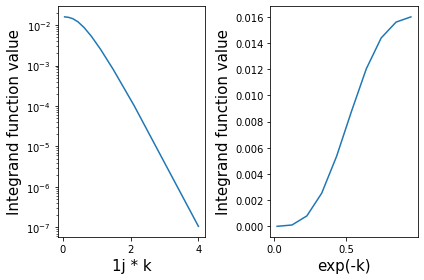

In [14]:
%matplotlib inline
from matplotlib.pyplot import figure

fig = figure()
ax1 = fig.add_subplot(121)
ax1.set_xlabel('1j * k', fontsize = 15)
ax1.set_ylabel('Integrand function value', fontsize = 15)
ax1.semilogy(-np.log(quad_points), -results)

ax2 = fig.add_subplot(122)
ax2.set_xlabel('exp(-k)', fontsize = 15)
ax2.plot(quad_points, -results)
ax2.set_ylabel('Integrand function value',fontsize = 15)
fig.tight_layout()